#### Preparing data
Run the next cells to download and prepare the datasets and util functions

In [1]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [2]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [3]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

In [4]:
if download_data:
    unzip_leaf_dataset()

#### Notebook start

In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from init import dataset_dir
from skimage import io
from skimage.transform import resize

# Leaf classification
To complete this task we can train different models. This models have to be training and test with data. For this we need have a train set and test set without lost the class balance in each set.

## Split data

In [7]:
os.listdir(dataset_dir)

['resize_image',
 'center_resize_image',
 'submissions',
 'test.csv',
 'images',
 'shapes.csv',
 'train.csv']

In [9]:
data = pd.read_csv(dataset_dir+"/train.csv").sort_values("id")
shapes = pd.read_csv(dataset_dir+"/shapes.csv", index_col=0).sort_values("id")
shapes = shapes[shapes.id.isin(data.id.values)]
shapes = shapes.reset_index(drop=True)

center_images = {i:io.imread(dataset_dir+"/center_resize_image/"+str(i)+".jpg") for i in data.id.values}
resize_images = {i:io.imread(dataset_dir+"/resize_image/"+str(i)+".jpg") for i in data.id.values}

In [10]:
data.shape, len(center_images), len(resize_images), shapes.shape

((990, 194), 990, 990, (990, 3))

## split params 
We have to define the portion of data to train and test.

In [11]:
split = 0.7
sample = lambda x:x.id.sample(frac=split).values.tolist()
train_ids = data.groupby("species").apply(sample).values.tolist()
train_ids = np.array(train_ids).flatten()
train_ids = train_ids[train_ids.argsort()]

In [12]:
get_test_ids = lambda x:x not in train_ids
test_ids = data[data.id.apply(get_test_ids)].id.sort_values().values

In [13]:
train_ids.shape, test_ids.shape

((693,), (297,))

In [14]:
set(train_ids).intersection(test_ids)

set()

### split features

In [15]:
train_features = data[data.id.isin(train_ids)]
test_features = data[data.id.isin(test_ids)]

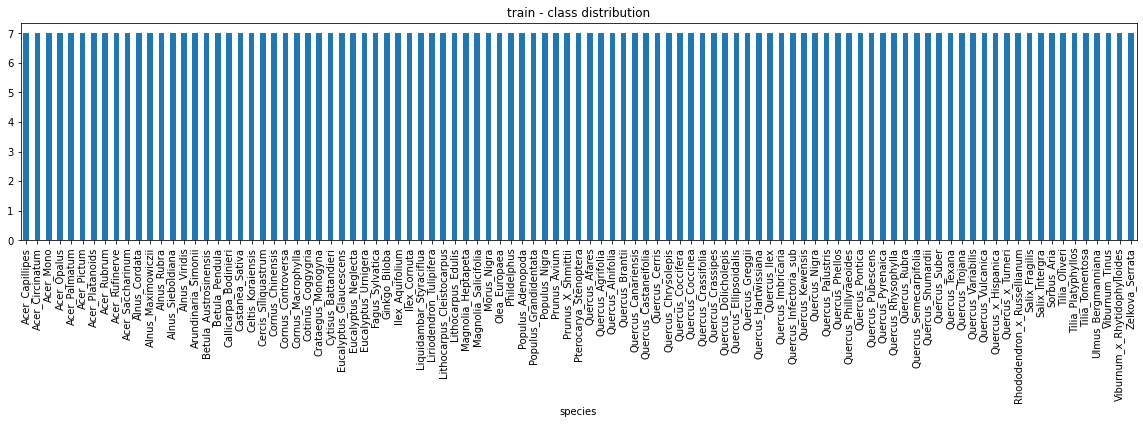

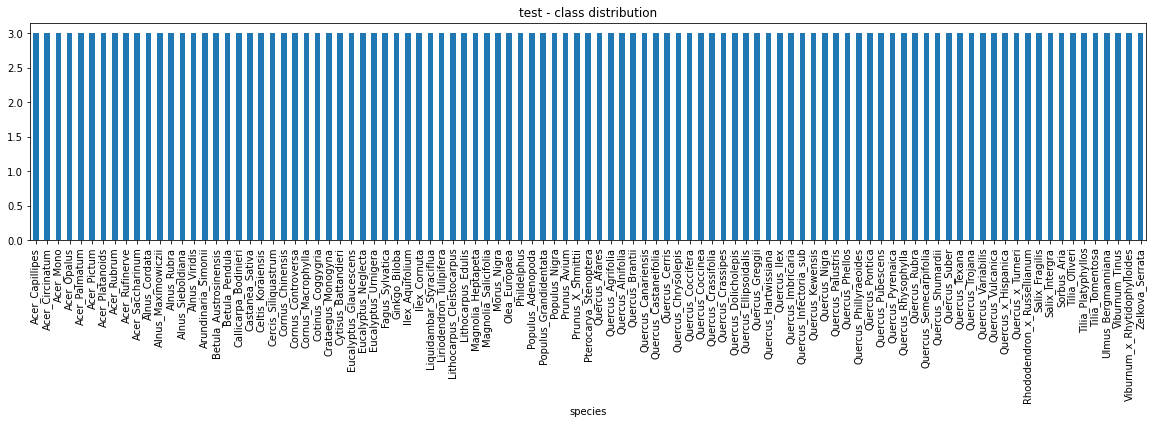

In [16]:
train_features.groupby("species").count().id.plot.bar(figsize=(20,4))
plt.title("train - class distribution")
plt.show()

test_features.groupby("species").count().id.plot.bar(figsize=(20,4))
plt.title("test - class distribution")
plt.show()

In [17]:
num_classes = data.species.value_counts().shape[0]
print("There are {} classes for the classification task.".format(num_classes))

There are 99 classes for the classification task.


In [18]:
species = data.species.value_counts().index.tolist()
species = {species[i]:i for i in range(len(species))}

In [19]:
set_target = lambda x:species[x]
train_features.loc[:, "target"] = train_features.species.apply(set_target).values
test_features.loc[:, "target"] = test_features.species.apply(set_target).values

/home/daielchom/Documents/envs/leaf-env/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/daielchom/Documents/envs/leaf-env/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
_ = train_features.pop("species")
_ = test_features.pop("species")

### split shapes

In [21]:
train_shapes = shapes[shapes.id.isin(train_ids)]
test_shapes = shapes[shapes.id.isin(test_ids)]

### split center images

In [22]:
train_center_images = {i:center_images[i] for i in center_images if i in train_ids}
test_center_images =  {i:center_images[i] for i in center_images if i in test_ids}

In [23]:
len(train_center_images), len(test_center_images)

(693, 297)

### split resize images

In [24]:
train_resize_images = {i:resize_images[i] for i in resize_images if i in train_ids}
test_resize_images =  {i:resize_images[i] for i in resize_images if i in test_ids}

In [25]:
len(train_resize_images), len(test_resize_images)

(693, 297)

# Train data

In [26]:
train_features.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,target
0,1,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391,43
1,2,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461,48
2,3,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930,41
3,5,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852,84
4,6,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250,15


In [27]:
train_shapes.head()

,id,image_height,image_width
0,1,0.308889,0.237233
1,2,0.068889,0.328378
2,3,0.296667,0.343891
3,5,0.307778,0.223659
4,6,0.157778,0.395604


In [32]:
idx = random.randint(0, 600)
tr_idx = train_ids[idx]

Text(0.5, 1.0, 'Train resize image sample\nshape: (128, 128)')

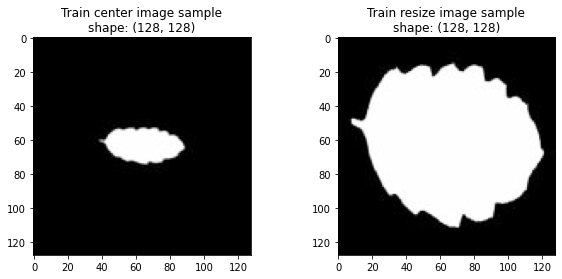

In [33]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(train_center_images[tr_idx], cmap="Greys_r")
plt.title("Train center image sample\nshape: {}".format(train_center_images[tr_idx].shape))

plt.subplot(122)
plt.imshow(train_resize_images[tr_idx], cmap="Greys_r")
plt.title("Train resize image sample\nshape: {}".format(train_resize_images[tr_idx].shape))

In [34]:
t1 = train_features.id.values
t2 = train_shapes.id.values
t3 = np.array(list(train_center_images.keys()))
t4 = np.array(list(train_resize_images.keys()))

In [35]:
print((t1== t2).mean())
print((t2==t3).mean())
print((t3==t4).mean())

1.0
1.0
1.0


# Test data

In [36]:
test_features.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,target
6,10,0.021484,0.031250,0.017578,0.009766,0.001953,0.042969,0.039062,0.000000,0.003906,...,0.000000,0.040039,0.000000,0.009766,0.0,0.0,0.000000,0.039062,0.003906,4
10,17,0.019531,0.031250,0.001953,0.005859,0.003906,0.013672,0.033203,0.000000,0.011719,...,0.000000,0.000000,0.002930,0.024414,0.0,0.0,0.006836,0.000000,0.004883,5
11,18,0.001953,0.001953,0.023438,0.025391,0.076172,0.000000,0.029297,0.000000,0.005859,...,0.003906,0.014648,0.003906,0.036133,0.0,0.0,0.012695,0.005859,0.000000,96
12,20,0.015625,0.011719,0.041016,0.003906,0.023438,0.015625,0.019531,0.000000,0.009766,...,0.000000,0.086914,0.000000,0.013672,0.0,0.0,0.000000,0.011719,0.002930,20
13,21,0.011719,0.011719,0.054688,0.017578,0.007812,0.009766,0.011719,0.007812,0.025391,...,0.000000,0.015625,0.000000,0.015625,0.0,0.0,0.000000,0.018555,0.022461,90


In [37]:
test_shapes.head()

,id,image_height,image_width
6,10,0.193333,0.451842
10,17,0.201111,0.362637
11,18,0.303333,0.418229
12,20,0.184444,0.371687
13,21,0.232222,0.367162


In [38]:
idx = random.randint(0, 290)
ts_idx = test_ids[idx]

Text(0.5, 1.0, 'Test resize image\nshape: (128, 128)')

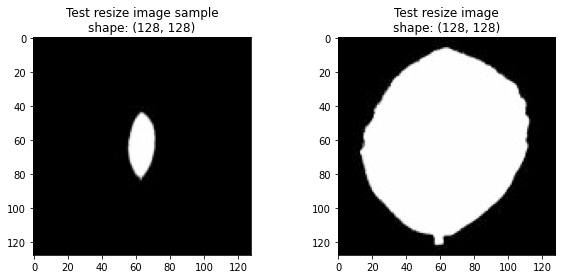

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(test_center_images[ts_idx], cmap="Greys_r")
plt.title("Test resize image sample\nshape: {}".format(test_center_images[ts_idx].shape))

plt.subplot(122)
plt.imshow(test_resize_images[ts_idx], cmap="Greys_r")
plt.title("Test resize image\nshape: {}".format(test_resize_images[ts_idx].shape))

In [40]:
t1 = test_features.id.values
t2 = test_shapes.id.values
t3 = np.array(list(test_center_images.keys()))
t4 = np.array(list(test_resize_images.keys()))

In [41]:
print((t1== t2).mean())
print((t2==t3).mean())
print((t3==t4).mean())

1.0
1.0
1.0
